**Titanic Survival Predictions using Logistic Regression**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


1. Importing python packages

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read train data
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")

# Read test data
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")


train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('Train data has the {} rows and {} columns'.format(train_df.shape[0],train_df.shape[1]))
print('Test data has the {} rows and {} columns'.format(test_df.shape[0],test_df.shape[1]))



Train data has the 891 rows and 12 columns
Test data has the 418 rows and 11 columns


### There are only 11 columns in test data as we will have to predict the the output of 12th column

2. Handling Missing Data 

In [4]:
# Checking which columns have missing values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

2.1  Age missing values

In [5]:
print('Almost {} percentage of age values are missing'.format(int((train_df.isnull()['Age'].sum()/train_df.shape[0])*100)))

Almost 19 percentage of age values are missing


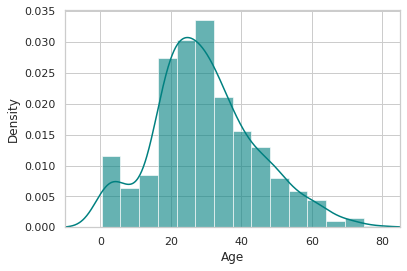

In [8]:
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)


ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

As the distribution is Right skewed we won't use Mean, but rather use median for unbiased results, but before we do that we are doing further analysis to find a better method to replace age.

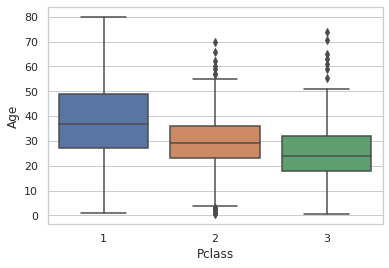

In [9]:
sns.boxplot(x ='Pclass', y = 'Age', data = train_df)
plt.show()

In [10]:
p1 = train_df[['Age']][train_df['Pclass']==1]
p2 = train_df[['Age']][train_df['Pclass']==2]
p3 = train_df[['Age']][train_df['Pclass']==3]
print('class 1 median age is {}'.format(p1.median()))
print('class 2 median age is {}'.format(p2.median()))
print('class 3 median age is {}'.format(p3.median()))

class 1 median age is Age    37.0
dtype: float64
class 2 median age is Age    29.0
dtype: float64
class 3 median age is Age    24.0
dtype: float64


As we can see that passengers from class 1 are older than class 2 and class 2 than class 3.
Thus we are going to replace age missing values by using class and replace it with individual class's median value

In [11]:
# a function to replace age by using class of individuals whose ages are missing
def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    if pd.isnull(age):
        if pclass == 1:
            return 37
        elif pclass == 2:
            return 29
        else :
            return 24  
    else:
        return age
    

2.2 Cabin missing values

In [12]:
print('Almost {} percentage of age values are missing'.format(int((train_df.isnull()['Cabin'].sum()/train_df.shape[0])*100)))

Almost 77 percentage of age values are missing


As these many values are missing therefore we will ignore this feature

2.3 Embarked Missing Values

In [13]:
train_df['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

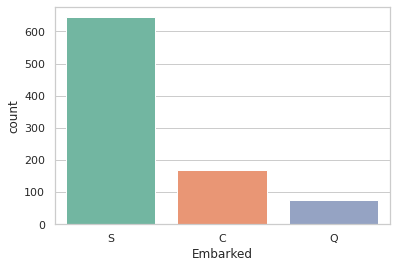

In [14]:
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

As only 2 values are missing therefore we are going to replace these with the most frequent observation 
that is 'S'.

2.4 Replacing the missing values and deleting the 'Cabin' feature

In [15]:
train_data = train_df.copy() # making a copy of training data
train_data['Age'].fillna(train_df['Age'].median(skipna =True),inplace =True)
train_data['Age'] = train_data[['Age','Pclass']].apply(impute_age, axis =1)
train_data['Embarked'].fillna(train_df['Embarked'].value_counts().idxmax(), inplace = True)
train_data.drop('Cabin', axis =1, inplace =True)

In [16]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Creating new features for the sake of simplicity and creating dummy variables

In [17]:
# Instead of using SibSp and Parch features we will combine them and make a new feature TravelAlone, and it 
# basically tells us whether a person was travelling alone or not

train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

In [18]:
# Creating dummy variables and droping the not required  features

training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)
final_train = training.copy()
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


Applying same changes to the the test data

In [19]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [20]:
p1 = test_df[['Age']][test_df['Pclass']==1]
p2 = test_df[['Age']][test_df['Pclass']==2]
p3 = test_df[['Age']][test_df['Pclass']==3]
print('class 1 median age is {}'.format(p1.median()))
print('class 2 median age is {}'.format(p2.median()))
print('class 3 median age is {}'.format(p3.median()))

class 1 median age is Age    42.0
dtype: float64
class 2 median age is Age    26.5
dtype: float64
class 3 median age is Age    24.0
dtype: float64


In [21]:
test_data = test_df.copy()


test_data['Age'] = test_data[['Age','Pclass']].apply(impute_age, axis =1)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


3.Exploratory Data Analysis

3.1 AGE VS SURVIVAL

Text(0.5, 1.0, 'Density distribution of Age of Survived v/s Not Survived')

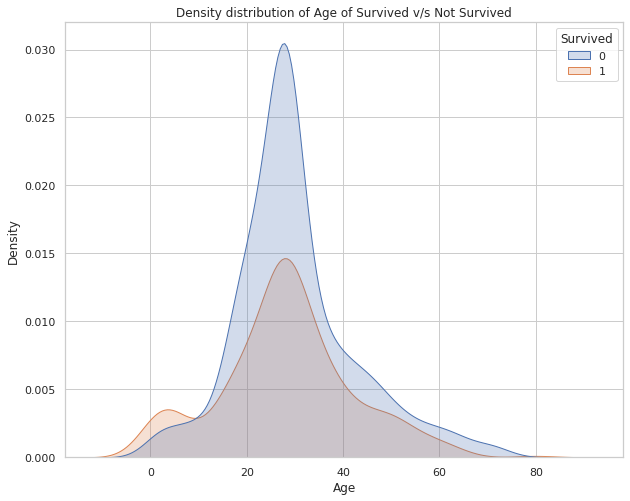

In [22]:
plt.figure(figsize = (10,8))
sns.kdeplot(x ='Age',data = final_train, hue = 'Survived',fill =True)
plt.title('Density distribution of Age of Survived v/s Not Survived')

From the distribution we can say that people from all the age groups died equally, but we can clearly see that kids under the age of 12-13 survived more, which should be obvious as people on the ship would have saved children first.

3.2 Fare vs Survival

(-20.0, 300.0)

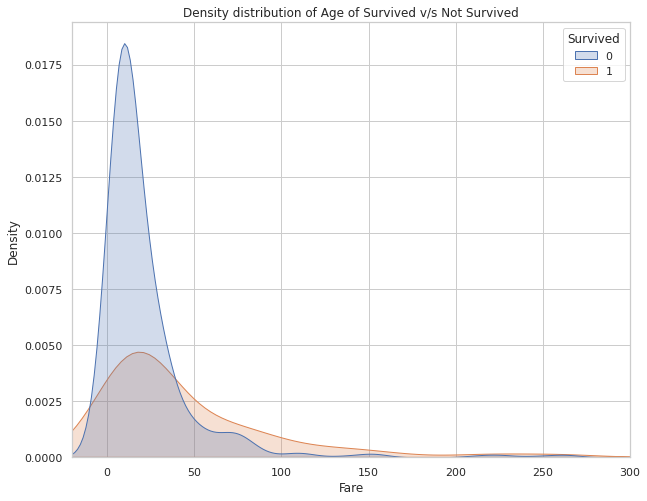

In [23]:
plt.figure(figsize = (10,8))
sns.kdeplot(x ='Fare',data = final_train, hue = 'Survived',fill =True)
plt.title('Density distribution of Age of Survived v/s Not Survived')
plt.xlim(-20,300)

From the distribution we can say that people who paid less died more as compared to people who paid more. This could be because of the placement of the costly cabins vs placement of low cost cabins

3.3 Passenger class vs Survival

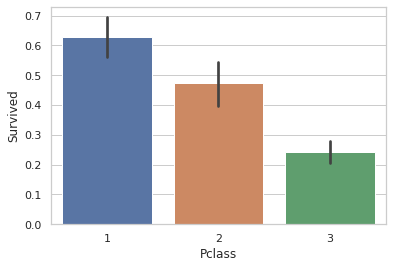

In [24]:
sns.barplot(x= 'Pclass',y = 'Survived', data=train_df)
plt.show()

Our suspicions from 3.3 section is confirmed as Passengers from class 1 and 2 survived more

3.4 Embarked vs Survival

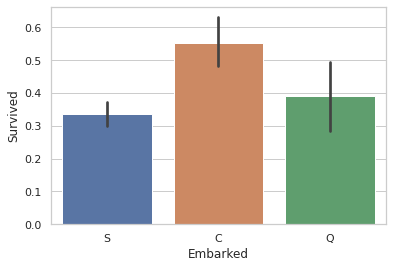

In [25]:
sns.barplot(x= 'Embarked',y = 'Survived', data=train_df)
plt.show()

Passengers who embarked from C = Cherbourg are more likely to have survived, again this might be because certain areas of ships were allocated to passengers depending on the embarked location.

3.5 TravelAlone vs Survival

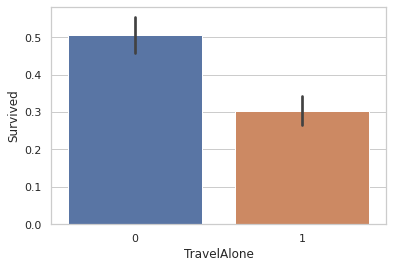

In [26]:
sns.barplot(x= 'TravelAlone',y = 'Survived', data=train_data)
plt.show()

People who travelled alone had less chance of survival, this might be due to the reason that while evacuating passengers children and women were given priorities and most likely they were not travelling alone.

3.6 Gender vs Survival

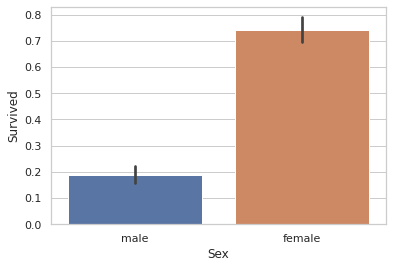

In [27]:
sns.barplot(x= 'Sex',y = 'Survived', data=train_df)
plt.show()

Women's survival rate was more and that is already explained in section 3.5

4. Logistic Regression 

In [28]:
final_train.corr()['Survived'].sort_values(ascending =False)

Survived       1.000000
Pclass_1       0.285904
Fare           0.257307
Embarked_C     0.168240
Pclass_2       0.093349
Embarked_Q     0.003650
Age           -0.064910
Embarked_S    -0.149683
TravelAlone   -0.203367
Pclass_3      -0.322308
Sex_male      -0.543351
Name: Survived, dtype: float64

In [29]:
from sklearn.linear_model import LogisticRegression


Finding optimal Features for our analysis using Recursive Feature Selection with cross validation

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Optimal number of features: 9
Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male', 'Pclass_3']


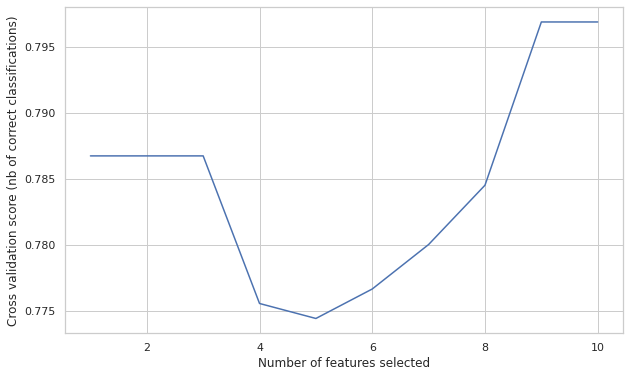

In [30]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(max_iter=200), step=1, cv=10, scoring='accuracy')
cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_Q","Embarked_S","Sex_male","Pclass_3"]
X = final_train[cols]
y = final_train['Survived']
rfecv.fit(X, y)

print("Optimal number of features: {}".format( rfecv.n_features_))
print('Selected features: {}'.format(  list(X.columns[rfecv.support_])))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

We are keeping only the 9 optimal features for further evaluation

In [32]:
Selected_features= ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
                    'Sex_male', 'Pclass_3']




In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss


X = final_train[Selected_features]
y = final_train['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


print('Results:')
print('Logistic Regression accuracy is {}'.format(accuracy_score(y_test, y_pred)))


Results:
Logistic Regression accuracy is 0.7932960893854749


In [34]:
# checking no. of correct predictions and incorrect predictions
confusion_matrix(y_test,y_pred)

array([[88, 17],
       [20, 54]])

Calculating Accuracy using cross validation

In [35]:
scores = cross_val_score(lr, X, y, cv=10, scoring='accuracy')

print('10-fold cross-validation results:')
print('Average accuracy is {}'.format(scores.mean()))

10-fold cross-validation results:
Average accuracy is 0.7980024968789013


Using Grid Search CV to find best parameters

In [36]:
from sklearn.model_selection import GridSearchCV

X = final_train[Selected_features]

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
#scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(max_iter = 200), return_train_score=True,
                  param_grid=param_grid, scoring='accuracy', cv=10, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


best params: LogisticRegression(C=0.50001, max_iter=150)
best params: {'C': 0.50001}
best score: 0.7991260923845194


GridSearchCV evaluating using multiple scorers, RepeatedStratifiedKFold and pipeline for preprocessing simultaneously

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

#Define simple model

C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy'}
lr = LogisticRegression(max_iter = 200)

#Simple pre-processing estimators

std_scale = StandardScaler(with_mean=False, with_std=False)
#std_scale = StandardScaler()

#Defining the CV method: Using the Repeated Stratified K Fold


n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

#Creating simple pipeline and defining the gridsearch


pipe = Pipeline(steps=[('scale',std_scale), ('clf',lr)])

log_clf = GridSearchCV(estimator= pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X, y)
results = log_clf.cv_results_

print('='*20)
print("best params: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
print('='*20)




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


best params: Pipeline(steps=[('scale', StandardScaler(with_mean=False, with_std=False)),
                ('clf', LogisticRegression(C=0.10001, max_iter=160))])
best params: {'clf__C': 0.10001}
best score: 0.7970937166530664


In [ ]:
final_test['Survived'] = log_clf.predict(final_test[Selected_features])
final_test['PassengerId'] = test_df['PassengerId']

submission = final_test[['PassengerId','Survived']]

submission.to_csv("submission.csv", index=False)

submission.head()

This Notebook was just about applying Logistic Regression.
Different Models can be used to get a better accuracy

array([[45,  8],
       [15, 22]])

array([[85, 15],
       [30, 49]])